# Dynamic Tropopause Map

 http://www.met.nps.edu/~hmarcham/2012.html#DT
 The dynamic tropopause map contains
 DT (2-PVU surface)
    - potential temperature (shaded, K)
    - wind barbs (knots)
    - 925-850hPa layer-averaged cyclonic relative vorticity (black contours, every 0.5 x 10^-4 s^-1)



 http://apps.ecmwf.int/codes/grib/param-db
 #### Parameters from ECMWF
    - name = 'Potential temperature',      shortName = 'pt',     [K]
    - name = 'U component of wind',        shortName = 'u',      [m s^-1]
    - name = 'V component of wind',        shortName = 'v',      [m s^-1]
    - name = 'Vorticity (relative)',       shortName = 'vo',     [s^-1]



https://software.ecmwf.int/wiki/display/CKB/How+to+plot+GRIB+files+with+Python+and+matplotlib

In [11]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
from scipy import ndimage
from datetime import date
import calendar



In [12]:
year = '2016'
mon = '12'
day = '10'
time = '00'

In [13]:
### define colors for colorbar
champ = 255
no1 = np.array([231,231,231])/champ
no2 = np.array([201,201,201])/champ
no3 = np.array([171,171,171])/champ
no4 = np.array([140,140,140])/champ
no5 = np.array([110,110,110])/champ
no6 = np.array([102,81,224])/champ
no7 = np.array([105,115,224])/champ
no8 = np.array([103,134,255])/champ
no9 = np.array([132,159,254])/champ
no10= np.array([178,202,255])/champ
no11= np.array([217,241,255])/champ
no12= np.array([255,209,177])/champ
no13= np.array([255,165,133])/champ
no14= np.array([255,118,86])/champ
no15= np.array([255,62,12])/champ
no16= np.array([255,0,0])/champ
no17= np.array([244,0,146])/champ
no18= np.array([171,171,171])/champ
no19= np.array([201,201,201])/champ
no20= np.array([231,231,231])/champ
no21= np.array([255,255,255])/champ

no22 = np.array([80,80,81])/champ

In [14]:
def opengrib(yyyy, mm, dd, tt, pm, path):
    grib = '%s/%s/param_%s_%s%s%s_%s00.grib' % (path,pm,pm,yyyy,mm,dd,tt)
    grbs = pygrib.open(grib)
    return(grbs);

In [15]:
def selectgrb(grbs, sN, tOL, lv):
    val = grbs.select()[0]
    val = grbs.select(shortName = sN, typeOfLevel = tOL, level = lv)[0]
    val = val.values
    return(val);

In [16]:
def shiftgrb(grb,val):
    lat,lon = grb.latlons()
    lons = lon[0,:]
    val,lons = shiftgrid(180., val, lons, start = False)
    lats = lat[:,0]
    
    lons,lats = np.meshgrid(lons,lats)
    plons,plats = m(lons,lats)
    return(plons,plats,lons,lats,val);

In [17]:
# use only every 20, 35 value from the wind
### Wind
def windsel(lonsU,latsU,wind_u,wind_v):
    lonsUV = lonsU[0,:]
    latsUV = latsU[:,0]
    
    UVlats = np.empty((64,),dtype=float)
    UVlons = np.empty((74,),dtype=float)
    
    u_wind = np.empty((64,2560),dtype = float)
    u_wind[:] = np.NAN

    v_wind = np.empty((64,2560),dtype = float)
    v_wind[:] = np.NAN

    u_wind2 = np.empty((64,74),dtype = float)
    u_wind2[:] = np.NAN

    v_wind2 = np.empty((64,74),dtype = float)
    v_wind2[:] = np.NAN

    for i in range(0,64):
        UVlats[i] = latsUV[i*20]
        u_wind[i,:] = wind_u[i*20,:]
        v_wind[i,:] = wind_v[i*20,:]
    
    for k in range(0,74):
        UVlons[k] = lonsUV[k*35]
        u_wind2[:,k] = u_wind[:,k*35]
        v_wind2[:,k] = v_wind[:,k*35]
        
    UVlons,UVlats = np.meshgrid(UVlons,UVlats)
    plonsUV,platsUV = m(UVlons,UVlats)
    return(plonsUV,platsUV,u_wind2,v_wind2);

In [18]:
### OPEN FILES
path = '../test_dataECMWF/SCA/PV2000'

### PT
parameter = 'pt'
grbsPT = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)

### Wind
parameter = 'uv'
grbsUV = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)

### Vorticity (relative)
path = '../test_dataECMWF/SCA/pl'
parameter = 'vo'
grbsVO = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)
#

In [19]:
### GET FILE DATA
tOL = 'potentialVorticity'
lv = 2000
### PT
sN = 'pt'
grbPT = grbsPT.select()[0]
PT = selectgrb(grbsPT, sN, tOL, lv)

### Wind 
# U component of wind
sN = 'u'
grbUV = grbsUV.select()[0]
wind_u = selectgrb(grbsUV, sN, tOL, lv)
# V component of wind
sN = 'v'
wind_v = selectgrb(grbsUV, sN, tOL, lv)

### Vorticity (relative)
# 925 hPa
sN = 'vo'
tOL = 'isobaricInhPa'
grbVO = grbsVO.select()[0]
lv = [850, 900, 925]

RV = dict()
for i in lv:
    RV[i] = selectgrb(grbsVO, sN, tOL, i)

In [20]:
### calculating 925-850 hPa layer-averaged cyclonic relative vorticity (every 0.5 x10^-4 s-1)
# all three layers divided by number of layers
rel_vort = (RV[850]+RV[900]+RV[925])/3          # arithmetric mean
rel_vort = ndimage.filters.gaussian_filter(rel_vort, sigma = 2)

In [21]:
# Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html
m = Basemap(projection='merc', \
            llcrnrlon=-80., urcrnrlon=50., \
            llcrnrlat=15.,urcrnrlat=75., \
            resolution='l')

In [22]:
### Latitudes, Longitudes and shiftgrid


plonsPT,platsPT,lonsPT,latsPT, PT = shiftgrb(grbPT,PT)
plonsVO,platsVO,lonsVO,latsVO, rel_vort = shiftgrb(grbVO,rel_vort)
plonsU,platsU,lonsU,latsU, wind_u = shiftgrb(grbUV,wind_u)
plonsV,platsV,lonsV,latsV, wind_v = shiftgrb(grbUV,wind_v)




In [23]:
### Wind
# use only every 20, 35 value from the wind
plonsUV,platsUV,u_wind, v_wind = windsel(lonsU,latsU,wind_u,wind_v)



In [24]:
### Dates for plotting
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]


### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html




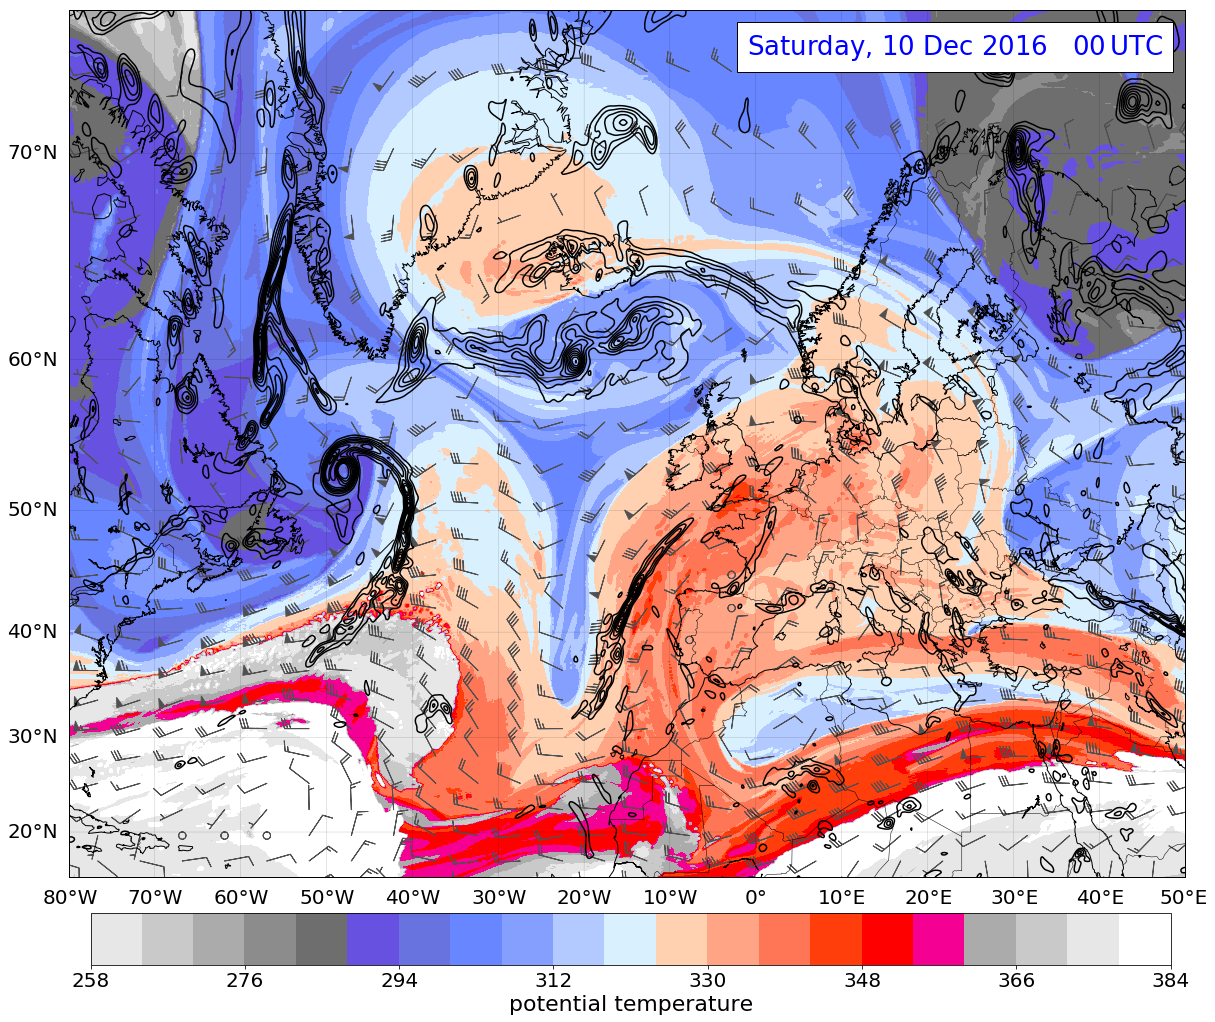

In [25]:
### PLOT FIGURE
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(1,1,1)



### Draw Latitude Lines
m.drawparallels(np.arange(-90.,120.,10.),labels=[1,0,0,0],fontsize=20,linewidth=0.2)


### Draw Longitude Lines
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,0,1],fontsize=20,linewidth=0.2)


### Draw Map
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()


### Plot contour lines for pot. temp and fill
levels = np.arange(258,390,6)
cmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7, no8, no9, no10, \
                              no11, no12, no13, no14, no15, no16, no17, no18, no19, no20, \
                             no21])
norm = colors.BoundaryNorm(boundaries = levels, ncolors=cmap.N)
cs = m.contourf(plonsPT,platsPT,PT,levels,norm=norm,cmap=cmap)




### Plot contour lines for layer averaged rel. vort 925-850 hPa
thickness = np.arange(.5*10**(-4), 6*10**(-4),.5*10**(-4))
CVO = m.contour(plonsVO,platsVO,rel_vort,thickness,colors='k')

### plot wind barbs
m.barbs(plonsUV,platsUV,u_wind,v_wind,barbcolor=[no22]) #darkslategray


### Add Colorbar
cbaxes = fig.add_axes([0.14, 0.05, .75, .045] )   #[left, bottom, width, height] 
cbar = plt.colorbar(cs,orientation='horizontal',cax = cbaxes)#, cax = cbaxes)#, shrink=0.5)
cbar.ax.set_xlabel('potential temperature',fontsize=22)
cbar.ax.tick_params(labelsize=20) 
#cbar.ax.set_aspect(50)


### Add Textbox
ax.text(0.98,0.94, '%s, %s %s %s   %s$\,$UTC' %(calday, day, calmon, year, time),
       verticalalignment = 'bottom',  horizontalalignment='right',
       transform = ax.transAxes,
       color ='blue', fontsize=26,
       bbox={'facecolor':'white','alpha':1., 'pad':10})


### Title
#fig.suptitle('Dynamic Tropopause Map at 2 PVU', fontsize=16, fontweight='bold') 
#ax.set_title('wind barbs (m$\,$s$^{-1}$), \n \
#potential temperature (K, shaded according to colorbar), \n \
#925-850$\,$hPa layer-averaged cyclonic relative vorticity (black contours, every 0.5 x 10$^{-4}$$\,$s$^{-1}$) \n', \
#            fontsize=13)



### Save
plt.savefig('../synoptic_figs/DynTropo/%s%s%s_%s.png' % (year, mon, day,time))
## with header
#plt.savefig('../synoptic_figs/DynTropo/%s%s%s_%s_header.png' % (year, mon, day,time))
#plt.savefig('dyn_tropo.png')     # Set the output file name

plt.show()
plt.close()